# The Soup-to-Nuts Random Forest Notebook

In [225]:
data_aug = False
use_majority_bader = False
bader_to_use = 'all'
pm_aug_minority_classes_only = False
use_normalized = False
norm_str = 'max' if use_normalized else 'feff'

drop_poly_problems = True


In [226]:
import sys
import os
import sklearn
import json
import numpy as np
import scipy.special as spec
from tabulate import tabulate
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
sys.path.append('/n/home11/storrisi/TRIX/X-Ray-Spectroscopy')
from trixs.spectra.core import XAS_Spectrum, XAS_Collation
from trixs.spectra.util import NumpyEncoder
from trixs.machine_learning.benchmarks import precision_recall_matrix, confusion_dict
from scipy.stats import norm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
storage_directory = '/n/home11/storrisi/TRIX/data/final_XY/feff_november_backup'
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
rseed = 42
from trixs.spectra.spectrum_featurize import polynomialize_by_idx, gauge_polynomial_error


#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': 'Computer Modern Roman'})
#rc('text', usetex=False

## Define domains which will be used for x-axis labels later, as well as define the elements which will be imported for use

In [227]:
target_elements_groups=[('Ti','O'),('V','O'),('Cr','O'),
                        ('Mn','O'),('Fe','O'),('Co','O'),
                        ('Ni','O'),('Cu','O')]

x_domains = {  ('Co','O'):  np.linspace(7713.5, 7765.83,100),
               ('Fe','O'): np.linspace(7115.0, 7167.764,100),
               ('V','O'):  np.linspace(5468.0, 5520.631,100),
               ('Cu','O'): np.linspace( 8987.5, 9039.712,100),
               ('Ni','O'): np.linspace( 8336.5 ,8388.723,100),
               ('Cr','O'): np.linspace(5993.1, 6045.686,100),
               ('Mn','O'): np.linspace(6541.7, 6594.417,100),
               ('Ti','O'): np.linspace(4969.0, 5021.024,100)}

colors_by_pair = {('Ti','O'):'orangered',
                  ('V','O'):'darkorange',
                  ('Cr','O'):'gold',
                  ('Mn','O'):'seagreen',
                  ('Fe','O'):'dodgerblue',
                  ('Co','O'):'navy',
                  ('Ni','O'):'rebeccapurple',
                  ('Cu','O'):"mediumvioletred"}

pair_to_name={'Ti':"Titanium",'V':'Vanadium',
              'Cr':'Chromium','Mn':"Manganese",
              'Fe':"Iron",'Co':"Cobalt",
             'Ni':'Nickel','Cu':'Copper'}

In [228]:
def prune_outliers(mu):
    
    
    if mu[-1]==np.max(mu):
        return False
    
    if np.max(mu)>3:
        return False
    
    if np.max(mu) in mu[:10]:
        return False
    
    return True


def test_poly_error_fit(X_set,idxs,x_domain,error_bound=.1, use_norm = True):
    idx_keep = []
    
    for spec,idx in zip(X_set,idxs):
        
        within_bound = one_shot_poly_error_fit(x_domain,spec,
                                               use_norm=use_norm,error_bound=error_bound)
        
        if not within_bound:
            continue
        idx_keep.append(idx)
            
    print("Dropped {}".format(len(idxs)-len(idx_keep)))
    return idx_keep

def test_poly_error_fit_N(X_set, idxs, x_domain, error_bound=.1, use_norm = True):
    idx_keep = []
    
    for spec,idx in zip(X_set,idxs):
        
        within_bound = one_shot_poly_error_fit(x_domain,spec,
                                               use_norm=use_norm,
                                               error_bound=error_bound)
        
        if not within_bound:
            continue
        idx_keep.append(idx)
            
    return idx_keep, len(idxs)-len(idx_keep)

def one_shot_poly_error_fit(x_domain,mu,use_norm = True, error_bound = .1):
    
    if use_norm:
        poly_set = polynomialize_by_idx(x_domain,mu/np.max(mu),N=20,deg=3,label_type='frac')
    else:
        poly_set = polynomialize_by_idx(x_domain,mu,N=20,deg=3,label_type='frac')
    
    for poly in poly_set:
            poly.error = gauge_polynomial_error(poly.x,poly.y,poly,error='abs')
            if poly.error>.1:
                return False


    return True
    
    

# Load in Pointwise Data

In [229]:
data_by_pair = {pair:[] for pair in target_elements_groups}
for pair in tqdm_notebook(target_elements_groups,desc='Loading in data'):
    target_file = storage_directory + '/{}_{}_XY_feff_november.json'.format(pair[0],pair[1])
    cur_x = x_domains[pair]
    with open(target_file, 'r') as f:
        raw_count = 0
        ineligible = 0
        outliered = 0
        unfeaturized = 0 
        for line in f.readlines():
            cur_data = json.loads(line)
            raw_count+=1  
           
            if not (cur_data.get('coordination') in [4,5,6] or cur_data.get('bader')):
                ineligible +=1
                continue
            
            if not prune_outliers(cur_data['mu']):
                outliered +=1
                continue
                
            if not one_shot_poly_error_fit(x_domains[pair],cur_data['mu']):
                unfeaturized +=1
                continue
            
            data_by_pair[pair].append(cur_data)
            
    print(f"{pair}: Raw total:{raw_count}, Kept: {len(data_by_pair[pair])}, Ineligible={ineligible}, Outliered={outliered}, Unfeaturized= {unfeaturized},")
#print("Sample data includes:",data_by_pair[pair][5].keys())

('Ti', 'O'): Raw total:4930, Kept: 4793, Ineligible=57, Outliered=26, Unfeaturized= 54,
('V', 'O'): Raw total:7120, Kept: 6929, Ineligible=30, Outliered=12, Unfeaturized= 149,
('Cr', 'O'): Raw total:2542, Kept: 2395, Ineligible=8, Outliered=18, Unfeaturized= 121,
('Mn', 'O'): Raw total:8504, Kept: 7917, Ineligible=42, Outliered=504, Unfeaturized= 41,
('Fe', 'O'): Raw total:7362, Kept: 6744, Ineligible=25, Outliered=523, Unfeaturized= 70,
('Co', 'O'): Raw total:3533, Kept: 3453, Ineligible=7, Outliered=66, Unfeaturized= 7,
('Ni', 'O'): Raw total:3420, Kept: 3396, Ineligible=11, Outliered=12, Unfeaturized= 1,
('Cu', 'O'): Raw total:3496, Kept: 3444, Ineligible=21, Outliered=31, Unfeaturized= 0,



Define the prune outliers function:

# Set up Confusion Matrix

In [230]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def avg_f1_score(guesses,labels):
    f1_score = precision_recall_matrix(guesses,labels,[4,5,6])
    return np.mean([np.round(100*x[2],1) for x in f1_score])

# Set up train/test sets, using indices to allow for easier data augmentation

In [231]:
ttc_by_pair = {pair:{} for pair in target_elements_groups}
ttb_by_pair = {pair:{} for pair in target_elements_groups}
ttnn_by_pair = {pair:{} for pair in target_elements_groups}
ttmd_by_pair = {pair:{} for pair in target_elements_groups}


for pair in target_elements_groups:
    
    np.random.seed(rseed)

    X_c = []; X_c_st =[] ; X_c_sq = [];
    X_c_p1 = []; X_c_m1 = []; M_c = []
    Y_c = []
    
    # Bader
    X_b = [];
    X_b_st = []; X_b_sq = []; 
    X_b_p1 = []; X_b_m1 = []

    Y_b = [] # bader value
    
    # NN dist max - min
    X_nn = [];
    X_nn_st = []; X_nn_sq = []; 
    X_nn_p1 = []; X_nn_m1 = []
    Y_nn = []; Y_md = [] 
    
    coord_tally = [bool(point.get('coordination') in [4,5,6]) for point in data_by_pair[pair]]
    bader_tally = [bool(point.get('bader')) for point in data_by_pair[pair]]
    
    pruned_coord_env    = []
    
    ############################
    # EXTRACT DATA FROM POINTS #
    ############################
    discounted_md = 0
    ineleigible = 0
    outliered = 0
    unfeaturized = 0
    for point in data_by_pair[pair]:
            
        if point.get('coordination') in [4,5,6]:
            if use_normalized:
                
                X_c.append(point['mu_norm'])
                
                X_c_p1.append(point['mu_p1']/np.max(point['mu_p1']))
                X_c_m1.append(point['mu_m1']/np.max(point['mu_m1']))

                X_c_st.append(point['mu_stretch']/np.max(point['mu_stretch']))
                X_c_sq.append(point['mu_squeeze']/np.max(point['mu_squeeze']))
                
            else:
                X_c.append(point['mu'])
                
                X_c_st.append(point['mu_stretch'])
                X_c_sq.append(point['mu_squeeze'])
                
                X_c_p1.append(point['mu_p1'])
                X_c_m1.append(point['mu_m1'])
            
            Y_c.append(point['coordination'])
            M_c.append(point['metadata'])
            
        if point.get('bader'):
            
            if bader_to_use == 'all':
                
                if use_normalized:
                    X_b.append(point['mu_norm'])
                    X_b_st.append(point['mu_stretch']/np.max(point['mu_stretch']))
                    X_b_sq.append(point['mu_squeeze']/np.max(point['mu_squeeze']))
                    X_b_p1.append(point['mu_p1']/np.max(point['mu_p1']))
                    X_b_m1.append(point['mu_m1']/np.max(point['mu_m1']))
                else:
                    X_b.append(point['mu'])
                    X_b_st.append(point['mu_stretch'])
                    X_b_sq.append(point['mu_squeeze'])
                    X_b_p1.append(point['mu_p1'])
                    X_b_m1.append(point['mu_m1'])

                Y_b.append(point['bader'])       
                
        if point.get('nn_min-max') is not None and point.get('coordination') in [4,5,6]:
                
            if use_normalized:
                X_nn.append( point['mu_norm'])
                
                X_nn_st.append(point['mu_stretch']/np.max(point['mu_stretch']))
                X_nn_sq.append(point['mu_squeeze']/np.max(point['mu_squeeze']))
                
                X_nn_p1.append(point['mu_p1']/np.max(point['mu_p1']))
                X_nn_m1.append(point['mu_m1']/np.max(point['mu_m1']))
            else:
                X_nn.append(point['mu'])
                
                X_nn_st.append(point['mu_stretch'])
                X_nn_sq.append(point['mu_squeeze'])
                
                X_nn_p1.append(point['mu_p1'])
                X_nn_m1.append(point['mu_m1'])
            
            Y_nn.append(point['nn_min-max'])    
            Y_md.append(point['avg_nn_dists'])
            
        elif point.get('nn_min-max') is not None:
            discounted_md += 1
        
    
    print("{} Coordination Data Points:".format(pair),len(Y_c), [str(x)+":"+str(Counter(Y_c)[x]) for x in sorted(Counter(Y_c).keys())])
    print("{} Bader Data Points:".format(pair),len(Y_b))
    print("{} Nearest Neighbor Data Points Used:".format(pair),len(Y_md),'/',discounted_md)

    #print("Pruned {} outliers with stats like:".format(len(pruned_coord_env)),Counter(pruned_coord_env))
    
    all_coord_indices = [n for n in range(len(Y_c))]
    all_bader_indices = [n for n in range(len(Y_b))]
    
    X_c = np.array(X_c);  
    X_c_p1 = np.array(X_c_p1); X_c_m1 = np.array(X_c_m1)
    X_c_sq = np.array(X_c_sq); X_c_st = np.array(X_c_st)
    Y_c = np.array(Y_c)


    X_b = np.array(X_b); 
    X_b_p1 = np.array(X_b_p1) ;X_b_m1 = np.array(X_b_m1)
    X_b_sq = np.array(X_b_sq); X_b_st = np.array(X_b_st)
    Y_b = np.array(Y_b)
  
    X_nn = np.array(X_nn)    
    X_nn_p1 = np.array(X_nn_p1); X_nn_m1 = np.array(X_nn_m1)
    X_nn_st = np.array(X_nn_st); X_nn_sq = np.array(X_nn_sq)
    Y_nn = np.array(Y_nn); Y_md = np.array(Y_md)

    
    ##########################
    # COORDINATION SETUP
    ##########################
    c_train_idx , c_test_idx, _, _ = \
          train_test_split(all_coord_indices,all_coord_indices, test_size=0.1,
                   random_state=rseed)
    c_train_idx , c_valid_idx, _, _ = \
          train_test_split(c_train_idx,c_train_idx, test_size=0.1,
                   random_state=rseed)
    
    if drop_poly_problems:
        c_train_idx, c_drop_train = test_poly_error_fit_N(X_c,c_train_idx,x_domains[pair])
        c_valid_idx, c_drop_valid = test_poly_error_fit_N(X_c,c_valid_idx,x_domains[pair])
        c_test_idx, c_drop_test  = test_poly_error_fit_N(X_c,c_test_idx, x_domains[pair])
        #print(f"Dropped for {pair} coord: {c_drop_train+c_drop_valid+c_drop_test}")
    
    c_squeeze_idx = np.random.choice(c_train_idx,size=int(.3*len(c_train_idx)),replace=False)
    c_stretch_idx = np.random.choice(c_train_idx,size=int(.3*len(c_train_idx)),replace=False)
    
    xc_train = X_c[c_train_idx]; yc_train = Y_c[c_train_idx]
    xc_valid = X_c[c_valid_idx]; yc_valid = Y_c[c_valid_idx]
    xc_test = X_c[c_test_idx]  ; yc_test = Y_c[c_test_idx]
    pre_aug = len(yc_train)
    
    if data_aug:
        xc_train = np.vstack((xc_train, 
                              X_c_p1[c_train_idx],
                              X_c_m1[c_train_idx],
                             X_c_sq[c_squeeze_idx],
                              X_c_st[c_stretch_idx]))
        yc_train = np.array(list(yc_train) 
                            + list(Y_c[c_train_idx]) 
                            + list(Y_c[c_train_idx])
                            + list(Y_c[c_squeeze_idx])
                            + list(Y_c[c_stretch_idx]))

    
    ros = RandomOverSampler(random_state = rseed)
    xc_train, yc_train = ros.fit_resample(xc_train,yc_train)
    
    
    ttc_by_pair[pair]['train_x'] = xc_train 
    ttc_by_pair[pair]['train_y'] = yc_train
    
    ttc_by_pair[pair]['valid_x'] = xc_valid
    ttc_by_pair[pair]['valid_y'] = yc_valid
    
    ttc_by_pair[pair]['test_x'] = xc_test
    ttc_by_pair[pair]['test_y'] = yc_test
    ttc_by_pair[pair]['valid_metadata'] = np.array(M_c)[c_valid_idx]
    
    print("{} Coordination Train/Train+Aug/Valid/Test Split: {}/{}/{}/{}".format(pair,pre_aug,len(yc_train),len(yc_valid),len(yc_test)))

    
    
    #############################################
    # BADER SETUP
    #############################################
    
    b_train_idx , b_test_idx, _, _ = \
          train_test_split(all_bader_indices,all_bader_indices, test_size=0.1,
                   random_state=rseed)
    b_train_idx , b_valid_idx, _, _ = \
          train_test_split(b_train_idx,b_train_idx, test_size=0.1,
                   random_state=rseed)
    
    if drop_poly_problems:
        
        b_train_idx, drop_train = test_poly_error_fit_N(X_b,b_train_idx,x_domains[pair])
        b_valid_idx, drop_valid = test_poly_error_fit_N(X_b,b_valid_idx,x_domains[pair])
        b_test_idx, drop_test = test_poly_error_fit_N(X_b,b_test_idx, x_domains[pair])
        #print(f"Dropped for {pair} bader: {drop_train+drop_valid+drop_test}")

    
    b_squeeze_idx = np.random.choice(b_train_idx,size=int(.3*len(b_train_idx)),replace=False)
    b_stretch_idx = np.random.choice(b_train_idx,size=int(.3*len(b_train_idx)),replace=False)
    
    yb_train = Y_b[b_train_idx]
    yb_valid = Y_b[b_valid_idx]
    yb_test  = Y_b[b_test_idx]

    xb_train = X_b[b_train_idx]
    xb_valid = X_b[b_valid_idx]
    xb_test  = X_b[b_test_idx]  
    
    if data_aug:
        xb_train = np.vstack((xb_train, 
                              X_b_p1[b_train_idx],
                              X_b_m1[b_train_idx], 
                              X_b_sq[b_squeeze_idx],
                              X_b_st[b_stretch_idx]))
        yb_train = np.array(list(yb_train)+ \
                            list(Y_b[b_train_idx])+ \
                            list(Y_b[b_train_idx])+ \
                            list(Y_b[b_squeeze_idx])+ \
                            list(Y_b[b_stretch_idx]))

        
    assert xb_train.shape[0] == len(yb_train)
    
    ttb_by_pair[pair]['train_x'] = xb_train 
    ttb_by_pair[pair]['train_y'] = yb_train
    
    ttb_by_pair[pair]['valid_x'] = xb_valid
    ttb_by_pair[pair]['valid_y'] = yb_valid
    
    ttb_by_pair[pair]['test_x'] = xb_test
    ttb_by_pair[pair]['test_y'] = yb_test
    
    
    ######################################################
    # NEIGHBOR PART
    ######################################################
    assert (len(Y_md)==len(Y_nn))
    all_nbr_indices = [n for n in range(len(Y_md))]

    nbr_train_idx , nbr_test_idx, _, _ = \
      train_test_split(all_nbr_indices,all_nbr_indices, test_size=0.1,
               random_state=rseed)
    nbr_train_idx , nbr_valid_idx, _, _ = \
      train_test_split(nbr_train_idx,nbr_train_idx, test_size=0.1,
                   random_state=rseed)
    
    if drop_poly_problems:
        
        nbr_train_idx, drop_train = test_poly_error_fit_N(X_nn,nbr_train_idx,x_domains[pair])
        nbr_valid_idx, drop_valid = test_poly_error_fit_N(X_nn,nbr_valid_idx,x_domains[pair])
        nbr_test_idx, drop_test  = test_poly_error_fit_N(X_nn,nbr_test_idx, x_domains[pair])
        #print(f"Dropped for {pair} mean: {drop_train+drop_valid+drop_test}")

    nn_squeeze_idx = np.random.choice(nbr_train_idx,size=int(.3*len(nbr_train_idx)),replace=False)
    nn_stretch_idx = np.random.choice(nbr_train_idx,size=int(.3*len(nbr_train_idx)),replace=False)
    

    # NEAREST NEIGHBOR DISTANCE MAX - MIN , UN NORMALIZED
    
    xnn_train = X_nn[nbr_train_idx]
    xnn_valid = X_nn[nbr_valid_idx]
    xnn_test = X_nn[nbr_test_idx]

    ymd_train = Y_md[nbr_train_idx]
    ymd_valid = Y_md[nbr_valid_idx]
    ymd_test  = Y_md[nbr_test_idx]
    
    assert xnn_train.shape[0] == len(ymd_train)
    
    if data_aug:
        xnn_train = np.vstack((xnn_train, 
                              X_nn_p1[nbr_train_idx],
                              X_nn_m1[nbr_train_idx], 
                               X_nn_sq[nn_squeeze_idx],
                              X_nn_st[nn_stretch_idx]))
        ymd_train = np.array(list(ymd_train)
                             + list(Y_md[nbr_train_idx])
                             + list(Y_md[nbr_train_idx])
                             + list(Y_md[nn_squeeze_idx])
                             +  list(Y_md[nn_stretch_idx]))
    
    
    assert xnn_train.shape[0] == len(ymd_train), str(xnn_train.shape) + str(len(ymd_train))
    
    ttnn_by_pair[pair]['train_x'] = xnn_train 
    ttnn_by_pair[pair]['valid_x'] = xnn_valid
    ttnn_by_pair[pair]['test_x'] = xnn_test
    
    # MEAN NEIGHBOR DISTANCE 

    ttmd_by_pair[pair]['train_y'] = ymd_train
    ttmd_by_pair[pair]['valid_y'] = ymd_valid
    ttmd_by_pair[pair]['test_y'] = ymd_test
    print('-----------')



('Ti', 'O') Coordination Data Points: 4709 ['4:334', '5:2301', '6:2074']
('Ti', 'O') Bader Data Points: 3201
('Ti', 'O') Nearest Neighbor Data Points Used: 4709 / 84
('Ti', 'O') Coordination Train/Train+Aug/Valid/Test Split: 3814/5514/424/471
-----------
('V', 'O') Coordination Data Points: 6862 ['4:1954', '5:2404', '6:2504']
('V', 'O') Bader Data Points: 3863
('V', 'O') Nearest Neighbor Data Points Used: 6862 / 67
('V', 'O') Coordination Train/Train+Aug/Valid/Test Split: 5557/6063/618/687
-----------
('Cr', 'O') Coordination Data Points: 2342 ['4:436', '5:580', '6:1326']
('Cr', 'O') Bader Data Points: 1809
('Cr', 'O') Nearest Neighbor Data Points Used: 2342 / 53
('Cr', 'O') Coordination Train/Train+Aug/Valid/Test Split: 1896/3213/211/235
-----------
('Mn', 'O') Coordination Data Points: 7810 ['4:302', '5:3873', '6:3635']
('Mn', 'O') Bader Data Points: 4031
('Mn', 'O') Nearest Neighbor Data Points Used: 7810 / 107
('Mn', 'O') Coordination Train/Train+Aug/Valid/Test Split: 6326/9453/703

In [232]:
print("Keys we can use:")
print(point.keys())

Keys we can use:
dict_keys(['guessed_oxy', 'E', 'mu', 'E0', 'k', 'mu0', 'chi', 'mu_stretch', 'mu_squeeze', 'mu_dilate', 'dilate_factor', 'mu_p1', 'mu_m1', 'mu_p2', 'mu_m2', 'mu_rand_shift', 'rand_shift', 'mu_norm', 'mu_norm_stretch', 'mu_norm_squeeze', 'coord_vector', 'coordination', 'one_hot_coord', 'nn_indexes', 'nn_species', 'nn_dists', 'avg_nn_dists', 'nn_min-max', 'mp_baders', 'oqmd_baders', 'valid_bader', 'oqmd_bader_avg', 'bader', 'metadata'])


# Optional: "ALL" Hyperparameter Optimization

In [233]:
from sklearn.metrics import f1_score, make_scorer

all_hyp_opt = False

from sklearn.model_selection import RandomizedSearchCV

if all_hyp_opt:
    with open("rf_all_hyp_opt.out",'w') as f:
        f.write('Beginning optimization...')
    best_est_by_pair={pair:None for pair in target_elements_groups}

    for pair in target_elements_groups[3:]:#[('Ti','O'),('V','O'),('Mn','O'),("Cu",'O')]:
        
        xc_train = ttc_by_pair[pair]['train_x']
        yc_train = ttc_by_pair[pair]['train_y']
        
        xc_valid = ttc_by_pair[pair]['valid_x']
        yc_valid = ttc_by_pair[pair]['valid_y']
        
        xb_train = ttb_by_pair[pair]['train_x']
        yb_train = ttb_by_pair[pair]['train_y']
        
        xb_valid = ttbn_by_pair[pair]['valid_x'] 
        yb_valid = ttbn_by_pair[pair]['valid_y']
        
        xnn_train = ttnn_by_pair[pair]['train_x']
        ymd_train = ttmd_by_pair[pair]['train_y']
        
        xnn_valid = ttnn_by_pair[pair]['valid_x']
        ymd_valid = ttmd_by_pair[pair]['valid_y']

        
        forest_c = RandomForestClassifier(random_state=rseed)
        forest_b = RandomForestRegressor(random_state=rseed)

        # RANDOM SEARCH SET
        debug = False
        if not debug:
            n_estimators= [50,75,100,150,200,250,300]
            max_depth=[10,15,20,25,30,35.40]
            min_samples_split= [2,3,5]
            min_samples_leaf = [1,2,4]
            #min_samples_split=[2]
            #min_samples_leaf=[1]
            max_features = [5,7,8,10,15,20,25,30]
         
        #DEBUG SET
        else:
            n_estimators= [25]
            max_depth=[15]
            min_samples_split=[2]
            min_samples_leaf=[1]
            max_features = [5]

            
        class_weight=['balanced',None]

        hyperF = dict(n_estimators=n_estimators, max_depth=max_depth,
                     min_samples_split = min_samples_split, 
                     min_samples_leaf = min_samples_leaf,
                     max_features = max_features,
                     class_weight=class_weight)
        
        #gridF_c = GridSearchCV(estimator=forest_c,
        #                       param_grid=hyperF,
        #                       scoring='f1_macro',
        #                       cv = 3, verbose = 3,n_jobs=4)
        randF_c = RandomizedSearchCV(estimator=forest_c,
                                    param_distributions=hyperF,
                                     scoring='f1_macro',
                                    n_iter =200,
                                     verbose=1,
                                    cv=5,n_jobs=4)
        bestF_c = randF_c.fit(xc_train,yc_train)
        the_best_c = bestF_c.best_estimator_
        
        
        best_est_by_pair[pair]= bestF_c.best_estimator_
        print(the_best_c)
        f1_score = precision_recall_matrix(fits=the_best_c.predict(xc_valid),
                                           labels=yc_valid,classes=[4,5,6])
        f1s = [np.round(100*x[2],1) for x in f1_score]
        
        with open("rf_all_hyp_opt.out",'a') as f:
            f.write("COORD SCORES FOR {}\n".format(pair))
            f.write("F1 scores: "+str(f1s)+ ' avg: ' + str(np.mean(f1s)))
            f.write("\nRF Score: {}\n".format(str(the_best_c.score(xc_valid,yc_valid))))
            f.write(str(bestF_c.best_estimator_))
            f.write("\n=======================================\n")
        
        bader_hyperF = dict(hyperF)
        bader_hyperF.pop('class_weight')
        
        randF_b = RandomizedSearchCV(estimator=forest_b,
                            param_distributions=bader_hyperF,
                            n_iter =200,
                             verbose=1,
                            cv=5,n_jobs=4)
        #gridF_b = GridSearchCV(forest_b,bader_hyperF, cv = 3, verbose = 1,n_jobs=4)
        bestF_b = randF_b.fit(xb_train,yb_train)
        the_best_b = bestF_b.best_estimator_
        
        print(the_best_b)
        with open("rf_all_hyp_opt.out",'a') as f:
            f.write("BADER SCORES FOR {}\n".format(pair))
            f.write("RF Score: {}\n".format(str(the_best_b.score(xb_valid,yb_valid))))
            f.write(str(bestF_b.best_estimator_))
            f.write("\n=======================================\n")
            
            
            
        md_hyperF = dict(bader_hyperF)
        gridF_md = GridSearchCV(forest_b,bader_hyperF, cv = 3, verbose = 1,n_jobs=4)
        randF_md = RandomizedSearchCV(estimator=forest_md,
                    param_distributions=bader_hyperF,
                    n_iter =200,
                     verbose=1,
                    cv=5,n_jobs=4)
        bestF_md = randF_md.fit(xnn_train,ymd_train)
        the_best_md = bestF_md.best_estimator_
        
        print(the_best_md)
        with open("rf_all_hyp_opt.out",'a') as f:
            f.write("MD SCORES FOR {}\n".format(pair))
            f.write("RF Score: {}\n".format(str(the_best_md.score(xnn_valid,ymd_valid))))
            f.write(str(bestF_md.best_estimator_))
            f.write("\n=======================================\n")
if all_hyp_opt:
    pprint(best_est_by_pair)

# The Big Cell 
# RF using pointwise spectra

beginning...


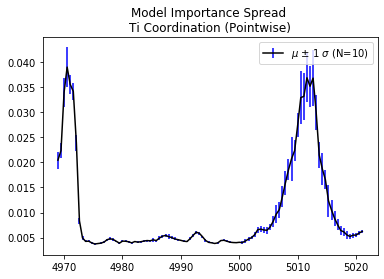

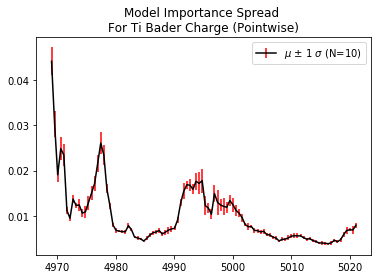

done.


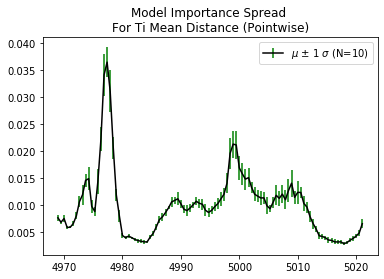

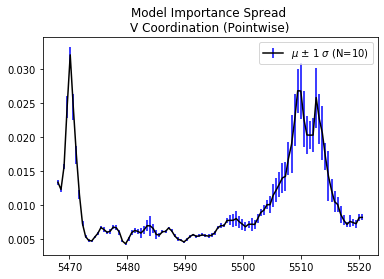

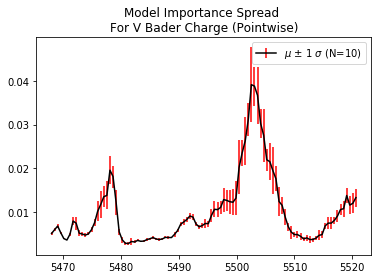

done.


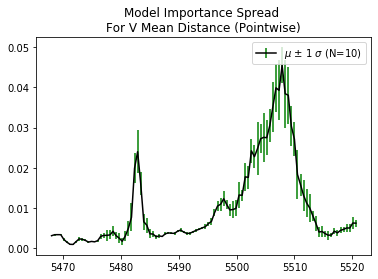

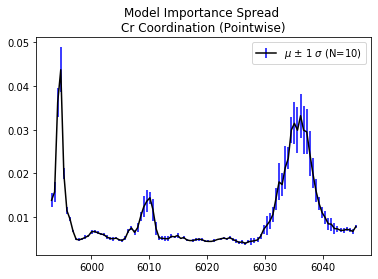

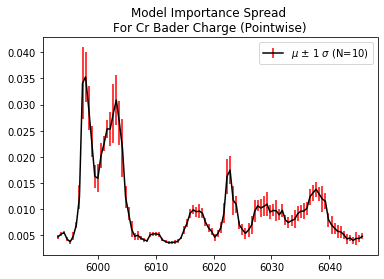

done.


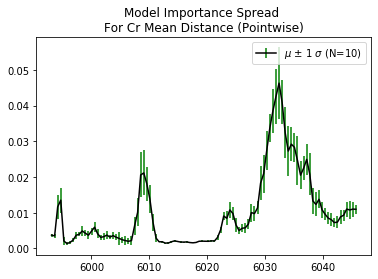

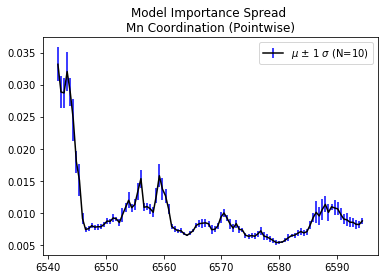

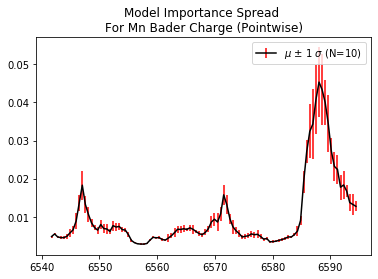

done.


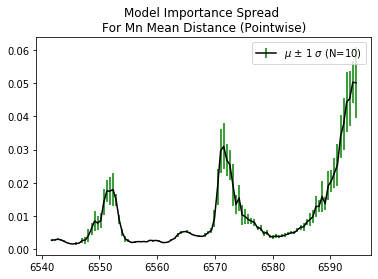

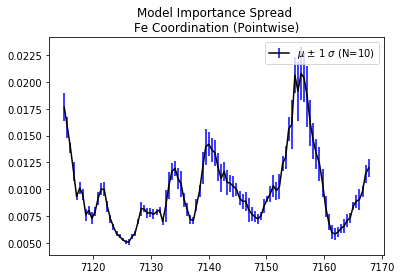

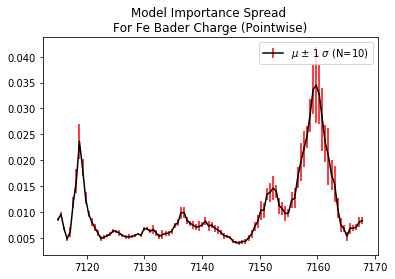

done.


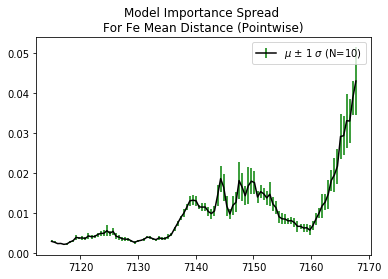

In [ ]:
run = True

show_plots = False
print("beginning...")


accuracies = {}
deviations = {}
all_data_values = []

md_perf_by_pair={}
bader_perf_by_pair={}
models_by_pair = {}
means_by_pair = {}


use_test = True
feature_rank_var = True

RANK_REPEAT = 9
N_ESTIMATORS = 300

for pair in target_elements_groups:
    if not run:
        continue
    forest_c = RandomForestClassifier(random_state=rseed,
                                      n_estimators=N_ESTIMATORS, #CHANE BACK TO 300
                                      max_depth =35, 
                                     max_features = 8, min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     class_weight=None,
                                     n_jobs=4)

    forest_b = RandomForestRegressor(random_state=rseed,
                      criterion='mse',max_depth=35,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=N_ESTIMATORS,
                                    n_jobs=4)
    
    
    forest_md = RandomForestRegressor(random_state=rseed,
                      criterion='mse',max_depth=35,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=N_ESTIMATORS,
                                     n_jobs=4)
        
    #############################################
    # COORDINATION
    #############################################
    #CAN CHANGE BETWEEN NORMALIZED AND UN-NORMALIZED
    xc_train = ttc_by_pair[pair]['train_x'] 
    yc_train = ttc_by_pair[pair]['train_y'] 

    if use_test:
        xc_valid = ttc_by_pair[pair]['test_x']
        yc_valid = ttc_by_pair[pair]['test_y'] 
    else:
        xc_valid = ttc_by_pair[pair]['valid_x'] 
        yc_valid = ttc_by_pair[pair]['valid_y']
    
        
    valid_metadata = ttc_by_pair[pair]['valid_metadata']
    
    
    forest_c.fit(xc_train,yc_train)
    ################## FEATURE RANK VARIANCE INTERLUDE ######################
    if feature_rank_var:
        cur_model_f1s = [[x[2]*100 for x in  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])]]
        cur_model_accuracies = [forest_c.score(xc_valid,yc_valid)]
        cur_model_importances = [forest_c.feature_importances_] 
        for i in range(RANK_REPEAT):
            forest_c.random_state = rseed+i+1
            forest_c.fit(xc_train,yc_train)
            cur_model_importances.append(forest_c.feature_importances_)
            cur_model_accuracies.append(forest_c.score(xc_valid,yc_valid))
            cur_model_f1s.append([x[2]*100 for x in
                                  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])])
        
        importances_mean = np.mean(cur_model_importances,axis=0)
        importances_std = np.std(cur_model_importances,axis=0)
        
        coord_accuracies_mean = np.mean(cur_model_accuracies)
        coord_accuracies_std = np.std(cur_model_accuracies)
        
        coord_f1s_mean = np.mean(cur_model_f1s, axis=0)
        coord_f1s_std = np.std(cur_model_f1s,   axis=0)


        means_by_pair[str(pair)+'-coord'] = importances_mean

        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='black',ecolor='blue')
        plt.title("Model Importance Spread \n{} Coordination (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig('gen_figures/{}_{}_all_coord_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()
        

    # Store a model
    models_by_pair[str(pair)+'-Coord'] = forest_c
    
    xdom = x_domains[pair]

    #############################################
    # BADER
    #############################################
    
    xb_train =  ttb_by_pair[pair]['train_x']
    yb_train =  ttb_by_pair[pair]['train_y']
    
    if use_test:
        xb_valid = ttb_by_pair[pair]['test_x']
        yb_valid = ttb_by_pair[pair]['test_y']
    else:
        xb_valid = ttb_by_pair[pair]['valid_x']
        yb_valid = ttb_by_pair[pair]['valid_y']
    
    
    forest_b.fit(xb_train,yb_train)    
    
    if feature_rank_var:
        cur_model_importances = [forest_b.feature_importances_] 
        cur_model_accuracies = [forest_b.score(xb_valid,yb_valid)]
        cur_model_maes = [np.mean(np.abs(forest_b.predict(xb_valid) - yb_valid))]
        
        for i in range(RANK_REPEAT):
            forest_b.random_state = rseed+i+1
            forest_b.fit(xb_train,yb_train)
            cur_model_importances.append(forest_b.feature_importances_)
            cur_model_accuracies.append(forest_b.score(xb_valid,yb_valid))
            cur_model_maes.append(np.mean(np.abs(forest_b.predict(xb_valid) - yb_valid)))
            
        importances_mean = np.mean(cur_model_importances,axis=0)
        importances_std  = np.std(cur_model_importances,axis=0)
        
        bader_accuracies_mean  = np.mean(cur_model_accuracies)
        bader_accuracies_std   = np.std(cur_model_accuracies)
        
        bader_maes_mean = np.mean(cur_model_maes)
        bader_maes_std = np.std(cur_model_maes)
        
        accuracies[str(pair)+'-Bader'] = bader_accuracies_mean
        deviations[str(pair)+'-Bader'] = bader_accuracies_std
        means_by_pair[str(pair)+'-Bader'] = importances_mean
        
        
        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='black',ecolor='red')
        plt.title("Model Importance Spread \nFor {} Bader Charge (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig('gen_figures/{}_{}_all_bader_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')

        plt.show()
    
    print("done.")
    models_by_pair[str(pair)+'-Bader'] = forest_b
    
    bader_perf_by_pair[pair[0]+'-guesses'] = forest_b.predict(xb_valid)
    bader_perf_by_pair[pair[0]+'-labels'] = yb_valid
    
    
    ##############################
    #   MD PART
    ##############################

    xnn_train = np.array(ttnn_by_pair[pair]['train_x'])
    ymd_train = np.array(ttmd_by_pair[pair]['train_y'])
    
    if use_test:
        xnn_valid = np.array(ttnn_by_pair[pair]['test_x'])
        ymd_valid = np.array(ttmd_by_pair[pair]['test_y'])
    else:
        xnn_valid = np.array(ttnn_by_pair[pair]['valid_x'])
        ymd_valid = np.array(ttmd_by_pair[pair]['valid_y'])
    
    md_perf_by_pair[pair[0]+'-labels'] = ymd_valid
    
    forest_md.fit(xnn_train,ymd_train)    
    
    if feature_rank_var:
        cur_model_importances = [forest_md.feature_importances_] 
        cur_model_accuracies = [forest_md.score(xnn_valid,ymd_valid)]
        cur_model_maes = [np.mean(np.abs(forest_md.predict(xnn_valid) - ymd_valid))]
        
        for i in range(RANK_REPEAT):
            forest_md.random_state = rseed+i+1
            forest_md.fit(xnn_train,ymd_train)
            cur_model_importances.append(forest_md.feature_importances_)
            cur_model_accuracies.append(forest_md.score(xnn_valid,ymd_valid))
            cur_model_maes.append(np.mean(np.abs(forest_md.predict(xnn_valid) - ymd_valid)))
            
        importances_mean = np.mean(cur_model_importances,axis=0)
        importances_std  = np.std(cur_model_importances,axis=0)
        
        md_accuracies_mean  = np.mean(cur_model_accuracies,axis=0)
        md_accuracies_std   = np.std(cur_model_accuracies,axis=0)
        
        md_maes_mean = np.mean(cur_model_maes,axis=0)
        md_maes_std = np.std(cur_model_maes,axis=0)

        means_by_pair[str(pair)+'-md'] = importances_mean

        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='black',ecolor='green')
        plt.title("Model Importance Spread \nFor {} Mean Distance (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig('gen_figures/{}_{}_all_md_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()
        
    
    models_by_pair[str(pair)+'-Mean'] = forest_md
    # Used in constructing parity plots later
    md_perf_by_pair[pair[0]+'-guesses'] = forest_md.predict(xnn_valid)    
    
    class_makeup = Counter(yc_valid)
    mode_guess_score = max(class_makeup.values())/sum(class_makeup.values())
    

    
    if feature_rank_var:
        #AVERAGES
        accuracies[str(pair)+'-Coord'] = np.round(coord_accuracies_mean*100,4)
        accuracies[str(pair)+'-Coord-F1'] = np.round(coord_f1s_mean,2)
        accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score*100,2)
        
        accuracies[str(pair)+'-Bader'] = np.round(bader_accuracies_mean*100,4)
        accuracies[str(pair)+'-Bader-MAE'] = np.round(bader_maes_mean,2)
        
        accuracies[str(pair)+'-MeanDist'] = np.round(md_accuracies_mean*100,4)
        accuracies[str(pair)+'-MeanDist-MAE'] = np.round(md_maes_mean,3)
        
        # DEVIATIONS
        deviations[str(pair)+'-Coord'] = np.round(coord_accuracies_std*100,4)
        deviations[str(pair)+'-Coord-F1'] = np.round(coord_f1s_std,4)
        
        deviations[str(pair)+'-Bader'] = np.round(bader_accuracies_std*100,4)
        deviations[str(pair)+'-Bader-MAE'] = np.round(bader_maes_std,4)
        
        deviations[str(pair)+'-MeanDist'] = np.round(md_accuracies_std*100,4)
        deviations[str(pair)+'-MeanDist-MAE'] = np.round(md_maes_std,4)
        
        #accuracies[str(pair)+'-PeakLocations']
        
    
    else:
        accuracies[str(pair)+'-Coord'] = np.round(forest_c.score(xc_valid,yc_valid),2)
        accuracies[str(pair)+'-Coord-F1'] = np.round(avg_f1_score(guesses=guesses,labels=yc_valid),2)
        accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score,2)
        
        accuracies[str(pair)+'-Bader'] = np.round(forest_b.score(xb_valid,yb_valid),2)
        accuracies[str(pair)+'-Bader-MAE'] = np.round(np.abs(forest_b.predict(xb_valid)-yb_valid).mean(),2)
        
        accuracies[str(pair)+'-MeanDist'] = np.round(forest_md.score(xnn_valid,ymd_valid),2)
        accuracies[str(pair)+'-MeanDist-MAE'] = np.round(np.abs(forest_md.predict(xnn_valid)-ymd_valid).mean(),2)
                         
        deviations[str(pair)+'-Coord'] = 0
        deviations[str(pair)+'-Coord-F1'] = 0
        deviations[str(pair)+'-GuessMode'] =0
        
        deviations[str(pair)+'-Bader'] = 0
        deviations[str(pair)+'-Bader-MAE'] = 0
        
        deviations[str(pair)+'-MeanDist'] =0
        deviations[str(pair)+'-MeanDist-MAE'] = 0
                                  
    
    all_data_values.append([pair[0],
                            accuracies[str(pair)+'-Coord'],
                            deviations[str(pair)+'-Coord'],
                            accuracies[str(pair)+'-Coord-F1'],
                            deviations[str(pair)+'-Coord-F1'],
                            accuracies[str(pair)+'-GuessMode'],
                            accuracies[str(pair)+'-Bader'],
                            deviations[str(pair)+'-Bader'],
                            accuracies[str(pair)+'-Bader-MAE'],
                            deviations[str(pair)+'-Bader-MAE'],
                            accuracies[str(pair)+'-MeanDist'],
                            deviations[str(pair)+'-MeanDist'],
                            accuracies[str(pair)+'-MeanDist-MAE'],
                            deviations[str(pair)+'-MeanDist-MAE']]
                          )
    
    

In [ ]:
headers=['Material', 
         'Coord Baseline', 
         'Coord Acc.',
         'Coord F1 (4)','Coord F1 (5)','Coord F1 (6)',
         'Bader $R^2$', 
         'Bader MAE', 
         'Mean NN $R^2$',
         'Mean NN-MAE',]

f = open('gen_figures/pointwise_table_{}.csv'.format(norm_str),'w')
print(str(headers).strip('[').strip(']').replace("'",""))
f.write(str(headers).strip('[').strip(']').replace("'","")+'\n')
avgs = [0 for _ in range(len(headers))]
for pair in target_elements_groups:
    i=1
    
    elt = pair[0]
    
    the_str = elt+','
    
    the_str += "%.2f" %accuracies[str(pair)+'-GuessMode'] +','
    avgs[i] += accuracies[str(pair)+'-GuessMode']; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord'] +' $\pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord']  +','
    avgs[i] += accuracies[str(pair)+'-Coord']; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][0] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][0] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][0]; i+=1;

    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][1] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][1] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][1]; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][2] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][2] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][2]; i+=1;



    
    the_str += "%.2f" %accuracies[str(pair)+'-Bader'] +' $\pm$'
    the_str += "%.2f" %deviations[str(pair)+'-Bader'] +','
    avgs[i] += accuracies[str(pair)+'-Bader']; i+=1;

    
    the_str += "%.3f" %accuracies[str(pair)+'-Bader-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations[str(pair)+'-Bader-MAE'] +' , '
    avgs[i] += accuracies[str(pair)+'-Bader-MAE']; i+=1;


    the_str += "%.2f" %accuracies[str(pair)+'-MeanDist'] +' $\pm$'
    the_str += "%.2f" %deviations[str(pair)+'-MeanDist'] +','
    avgs[i] += accuracies[str(pair)+'-MeanDist']; i+=1;

    
    the_str += "%.3f" %accuracies[str(pair)+'-MeanDist-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations[str(pair)+'-MeanDist-MAE']
    avgs[i] += accuracies[str(pair)+'-MeanDist-MAE']; i+=1;

    print(the_str)
    f.write(the_str+'\n')

avgs = list(np.round(np.array(avgs)/8,2))
avgs[0]='Avgs.'
print(str(avgs).strip('[').strip(']'))
f.write(str(avgs).strip('[').strip(']'))
f.close()

In [ ]:

plt.figure(dpi=300)
for pj, pair in enumerate(target_elements_groups):
    
    
    #avg = np.mean(accuracies[str(pair)+'-Coord-F1s'])/100
    
    plt.bar(pj+.5,accuracies[str(pair)+'-Coord']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           label=str(pair[0]),
           yerr = deviations[str(pair)+'-Coord']/100,capsize=1.5)
    plt.bar(pj+.5,accuracies[str(pair)+'-GuessMode']/100,color='lightgrey',width=1,alpha=1)
    plt.bar(pj+.5+8,accuracies[str(pair)+'-Coord-F1'][0]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][0]/100, capsize=1.5)
    
    plt.bar(pj+.5+2*8,accuracies[str(pair)+'-Coord-F1'][1]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][1]/100,capsize=1.5)
    
    plt.bar(pj+.5+3*8,accuracies[str(pair)+'-Coord-F1'][2]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][2]/100,capsize=1.5)
    
    plt.bar(pj+.5+4*8,accuracies[str(pair)+'-MeanDist']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations[str(pair)+'-MeanDist']/100,capsize=1.5)
    
    plt.bar(pj+.5+5*8,accuracies[str(pair)+'-Bader']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations[str(pair)+'-Bader']/100,capsize=1.5)
    
    
    
    
for i in [0,8,16,24,32,40]:
    plt.axvline(i,color='black',lw=1,ls='-')

for i in [.2,.4,.6,.8]:
    plt.axhline(i,color='gray',ls='--',alpha=.1)

#plt.axhline(.8,color='gray',ls='--',zorder=-1)
#plt.xticks([n*7+2.5 for n in range(8)],labels=[pair[0] for pair in target_elements_groups])
plt.xticks([8*i+4  for i in range(0,6)],
                labels=['Coordination\n Number (CN)\n Accuracy', 'F1\n(CN=4)', 'F1\n(CN=5)', 'F1\n(CN=6)',
                                      'Mean NN.\nDist. $R^2$','Bader\n$R^2$'],)
plt.xticks()
plt.xlim(0,6*7+6)
plt.ylim(0,1.0000001)
plt.ylabel('Figure of Merit')


plt.title("Accumulated Figures of Merit\n(Pointwise)")

plt.legend(loc='lower center',ncol=2,framealpha=.95)
plt.savefig('gen_figures/{}_all_perf.pdf'.format(norm_str),format='pdf',dpi=300,bbox_inches='tight')

# Performance of MD Fitting- Uniparity

In [ ]:

pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(md_perf_by_pair[pair[0]+'-guesses'])
    all_min = min(all_min, min(md_perf_by_pair[pair[0]+'-labels']),min(md_perf_by_pair[pair[0]+'-guesses']))
    all_max = max(all_max, max(md_perf_by_pair[pair[0]+'-labels']),max(md_perf_by_pair[pair[0]+'-guesses']))

    plt.scatter(md_perf_by_pair[pair[0]+'-labels'][0],
                    md_perf_by_pair[pair[0]+'-guesses'][0],
                    zorder=-1,
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 1,
                    label = pair[0] + " MAE: " +str(np.round((accuracies[str(pair)+'-MeanDist-MAE']),3)))
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(md_perf_by_pair[pair[0]+'-labels'][i],
                    md_perf_by_pair[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8)
plt.title("Mean Nearest-Neighbor Distance\nRegression Performance")
plt.xlabel("True Distance ($\AA$)")
plt.ylabel("Predicted Distance ($\AA$)")

plt.savefig('gen_figures/{}_md_uniparity.pdf'.format(norm_str),format='pdf',dpi=300,bbox_inches='tight')

plt.show()

## Bader Performance

In [ ]:

pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(bader_perf_by_pair[pair[0]+'-guesses'])
    all_min = min(all_min, min(bader_perf_by_pair[pair[0]+'-labels']),min(bader_perf_by_pair[pair[0]+'-guesses']))
    all_max = max(all_max, max(bader_perf_by_pair[pair[0]+'-labels']),max(bader_perf_by_pair[pair[0]+'-guesses']))

    plt.scatter(bader_perf_by_pair[pair[0]+'-labels'][0],
                bader_perf_by_pair[pair[0]+'-guesses'][0],
                zorder=-1,
                marker=pair_to_icon[pair[0]],
                color= colors_by_pair[pair], 
                alpha = 1,
                label=pair[0]+" MAE: "
                +str(np.round(accuracies[str(pair)+'-Bader-MAE'],2))) 
                #+f"\t R$^2$:{accuracies[str(pair)+'-Bader']:.2f}") 
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(bader_perf_by_pair[pair[0]+'-labels'][i],
                    bader_perf_by_pair[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8,loc='best')
plt.title("Bader Charge\nRegression Performance")
plt.xlabel("True Charge (e=1)")
plt.ylabel("Predicted\nCharge (e=1)")
plt.savefig('gen_figures/{}_bader_uniparity.pdf'.format(norm_str),format='pdf',dpi=300,bbox_inches='tight')

plt.show()

# END PART ONE
--------------

---------
#                     PART TWO: POLYNOMIALS

## Load in the Polynomial Fit Data

In [ ]:
print(storage_directory)
poly_data_by_pair = {pair:[] for pair in target_elements_groups}
for pair in tqdm_notebook(target_elements_groups,desc='Loading in data'):
    if use_normalized: 
        target_file = storage_directory + '/{}_{}_feff_maxnorm_november_polys_whole_curve_XY.json'.format(pair[0],pair[1])
    else: 
        target_file = storage_directory + '/{}_{}_feff_feffnorm_november_polys_whole_curve_XY.json'.format(pair[0],pair[1])
    with open(target_file, 'r') as f:
        for line in f.readlines():
            cur_data = json.loads(line)
            if cur_data.get('one_hot_coord') or cur_data.get('bader') or cur_data.get('nn_min-max'):
                poly_data_by_pair[pair].append(cur_data)
sorted_keys = sorted(list(poly_data_by_pair[pair][0]['labeled_coefficients'].keys()))
sorted_keys_filtered = [key for key in sorted_keys if ('fraction_size:1,' not in key and 'fraction_size:2,' not in key and 'random' not in key)]
sorted_keys = sorted_keys_filtered

In [ ]:
from pprint import pprint
#print(sorted_keys)

# Set up Polynomial TT Sets

In [ ]:
pttc_by_pair = {pair:{} for pair in target_elements_groups}
pttb_by_pair = {pair:{} for pair in target_elements_groups}

pttnn_by_pair = {pair:{} for pair in target_elements_groups}

pttmd_by_pair = {pair:{} for pair in target_elements_groups}

for pair in target_elements_groups:

    X_pc = []
    Y_pc = []
    
    X_pnn = []
    Y_pnn = []
    Y_md = []
    
    X_pb = []
    Y_pb = []
    
    for point in poly_data_by_pair[pair]:
        if point.get('coordination') in [4,5,6]:
            
            X_pc.append([point['labeled_coefficients'][key] for key in sorted_keys])
            Y_pc.append(point['coordination'])
    
        if point.get('coordination') in [4,5,6] and point.get('avg_nn_dists') is not None:
            X_pnn.append([point['labeled_coefficients'][key] for key in sorted_keys])
            Y_pnn.append(point['nn_min-max'])
            Y_md.append(point['avg_nn_dists'])

        if point.get('bader') is not None:
            X_pb.append([point['labeled_coefficients'][key] for key in sorted_keys])
            Y_pb.append(point['bader'])            

    print("{} Coordination Data Points:".format(pair),len(Y_pc))
    print("{} Bader Data Points:".format(pair),len(Y_pb))

    X_pc = np.array(X_pc)
    X_pb = np.array(X_pb)
    X_pnn = np.array(X_pnn)
    
    Y_pb = np.array(Y_pb)
    Y_pc = np.array(Y_pc)
    Y_pnn = np.array(Y_pnn)
    Y_md = np.array(Y_md)

    # COORDINATION ON POLYNOMIALS
    xc_train, xc_test, yc_train, yc_test = \
      train_test_split(X_pc, Y_pc, test_size=0.1,
                   random_state=rseed)
    xc_train, xc_valid, yc_train, yc_valid = \
      train_test_split(xc_train, yc_train, test_size=0.1,
                       random_state=rseed)
    
    ros = RandomOverSampler(random_state = rseed)
    #xc_train, yc_train = ros.fit_resample(xc_train,yc_train)
    
    pttc_by_pair[pair]['train_x'] = xc_train 
    pttc_by_pair[pair]['train_y'] = yc_train
    pttc_by_pair[pair]['valid_x'] = xc_valid
    pttc_by_pair[pair]['valid_y'] = yc_valid
    pttc_by_pair[pair]['test_x']  = xc_test
    pttc_by_pair[pair]['test_y']  = yc_test
    
    
    # BADER CHARGES ON POLYNOMIALS
    xbn_train, xbn_test, ybn_train, ybn_test = \
      train_test_split(X_pb, Y_pb, test_size=0.1,
                   random_state=rseed)
    xbn_train, xbn_valid, ybn_train, ybn_valid = \
      train_test_split(xbn_train, ybn_train, test_size=0.1,
                       random_state=rseed)
    
    pttb_by_pair[pair]['train_x'] = xbn_train 
    pttb_by_pair[pair]['train_y'] = ybn_train
    pttb_by_pair[pair]['valid_x'] = xbn_valid
    pttb_by_pair[pair]['valid_y'] = ybn_valid
    pttb_by_pair[pair]['test_x']  = xbn_test
    pttb_by_pair[pair]['test_y']  = ybn_test
    
    
    # Max - Min distance ON POLYNOMIALS
    
    all_nn_idx = [n for n in range(len(X_pnn))]
    nn_train_idx, nn_test_idx , _, _ = \
            train_test_split(all_nn_idx, all_nn_idx, test_size=0.1,
                               random_state=rseed)
    nn_train_idx, nn_valid_idx, _, _ = \
        train_test_split(nn_train_idx, nn_train_idx, test_size=0.1,
                                   random_state=rseed)
    
    xnn_train = X_pnn[nn_train_idx]
    xnn_valid = X_pnn[nn_valid_idx]
    xnn_test  = X_pnn[nn_test_idx]
    
    ynn_train = Y_pnn[nn_train_idx]
    ynn_valid = Y_pnn[nn_valid_idx]
    ynn_test  = Y_pnn[nn_test_idx]
    
    ymd_train = Y_md[nn_train_idx]
    ymd_valid = Y_md[nn_valid_idx]
    ymd_test  = Y_md[nn_test_idx]
    
    
    pttnn_by_pair[pair]['train_x'] = xnn_train 
    pttnn_by_pair[pair]['train_y'] = ynn_train
    pttnn_by_pair[pair]['valid_x'] = xnn_valid
    pttnn_by_pair[pair]['valid_y'] = ynn_valid
    pttnn_by_pair[pair]['test_x']  = xnn_test
    pttnn_by_pair[pair]['test_y']  = ynn_test
    
    pttmd_by_pair[pair]['train_y'] = ymd_train
    pttmd_by_pair[pair]['valid_y'] = ymd_valid
    pttmd_by_pair[pair]['test_y']  = ymd_test    
    

In [ ]:
for pair in target_elements_groups:
    for theset in ['test_x','test_y','valid_x','valid_y']:
        assert(len(pttc_by_pair[pair][theset]) == len(ttc_by_pair[pair][theset])), f"{pair},{theset}; {len(pttc_by_pair[pair][theset])}, {len(ttc_by_pair[pair][theset])} "
        assert(len(pttb_by_pair[pair][theset]) == len(ttb_by_pair[pair][theset]))

# Hyperparameters for Polynomial Fit

In [ ]:
poly_hyp_opt = False


best_poly_coord_forests={pair:None for pair in target_elements_groups}
best_poly_bader_forests={pair:None for pair in target_elements_groups}

if poly_hyp_opt:
    with open("rf_poly_hyp_opt.out",'w') as f:
        f.write('Beginning optimization...')
        
    for pair in target_elements_groups:
        
        
        xc_train = pttc_by_pair[pair]['train_x']
        yc_train = pttc_by_pair[pair]['train_y']
        xc_valid = pttc_by_pair[pair]['valid_x']
        yc_valid = pttc_by_pair[pair]['valid_y']

        xb_train = pttb_by_pair[pair]['train_x']
        yb_train = pttb_by_pair[pair]['train_y']
        xb_valid = pttb_by_pair[pair]['valid_x']
        yb_valid = pttb_by_pair[pair]['valid_y']

        
        xnn_train = pttnn_by_pair[pair]['train_x']
        ymd_train = pttnn_by_pair[pair]['train_y']
        xnn_valid = pttnn_by_pair[pair]['valid_x']
        ymd_valid = pttnn_by_pair[pair]['valid_y']


        forest_c = RandomForestClassifier(random_state=rseed)
        forest_b = RandomForestRegressor(random_state=rseed)

        debug = False
        if not debug:
            n_estimators= [50,75,100,150,200,250,300,400]
            max_depth=[15,20,25,30,35]
            min_samples_split=[2,3,5]
            min_samples_leaf=[1,2,3]
            max_features = [5,8,10,15,20,30,40,50] # NOTE: INCREASED
        else:
            min_samples_split=[2]
            min_samples_leaf=[2]
            n_estimators=[25,60]
            max_depth=[10]
            max_features=[2,5]

        
        class_weight = ['balanced',None]

        hyperF = dict(n_estimators=n_estimators, max_depth=max_depth,
                     min_samples_split = min_samples_split, 
                     min_samples_leaf = min_samples_leaf,
                     max_features = max_features,
                     class_weight = class_weight)
        
        
        
        
        gridF_c = GridSearchCV(forest_c,hyperF, cv = 2, verbose = 10,n_jobs=4)
        randF_c = RandomizedSearchCV(forest_c,hyperF,cv=2,verbose=1,n_jobs=4,n_iter=200)
        bestF_c = randF_c.fit(xc_train,yc_train)
        the_best_c = bestF_c.best_estimator_
        best_poly_coord_forests[pair] = the_best_c
        print(the_best_c)
        print("Accuracy:",the_best_c.score(xc_valid,yc_valid))
        
        f1_score = precision_recall_matrix(fits=the_best_c.predict(xc_valid),
                                           labels=yc_valid,classes=[4,5,6])
        f1s = [np.round(100*x[2],1) for x in f1_score]
        
        with open("rf_poly_hyp_opt.out",'a') as f:
            f.write("COORD SCORES FOR {}\n".format(pair))
            f.write("F1 scores: "+str(f1s)+ ' avg: ' + str(np.mean(f1s)))
            f.write("\nRF Score: {}\n".format(str(the_best_c.score(xc_valid,yc_valid))))
            f.write(str(bestF_c.best_estimator_))
            f.write("\n=======================================\n")
        
        regress_hyper_F = dict(hyperF); 
        regress_hyper_F.pop('class_weight')
        
        randF_b = RandomizedSearchCV(forest_b,regress_hyper_F,cv=5,verbose=1,n_jobs=4,n_iter=200)
        gridF_b = GridSearchCV(forest_b,regress_hyper_F, cv = 2, verbose = 5,n_jobs=4)
        bestF_b = randF_b.fit(xb_train,yb_train)
        the_best_b = bestF_b.best_estimator_

        
        with open("rf_poly_hyp_opt.out",'a') as f:
            f.write("BADER SCORES FOR {}\n".format(pair))
            f.write("\nRF Score: {}\n".format(str(the_best_b.score(xb_valid,yb_valid))))
            f.write(str(bestF_b.best_estimator_))
            f.write("\n=======================================\n")
        
        randF_md = RandomizedSearchCV(forest_b,regress_hyper_F,cv=5,verbose=1,n_jobs=4,n_iter=200)
        gridF_md = GridSearchCV(forest_b,regress_hyper_F, cv = 2, verbose = 5,n_jobs=4)
        bestF_md = randF_md.fit(xnn_train,ymd_train)
        the_best_md = bestF_md.best_estimator_
        
        with open("rf_poly_hyp_opt.out",'a') as f:
            f.write("MD SCORES FOR {}\n".format(pair))
            f.write("\nRF Score: {}\n".format(str(the_best_md.score(xnn_valid,ymd_valid))))
            f.write(str(bestF_md.best_estimator_))
            f.write("\n=======================================\n")

    

In [ ]:
not_peak_keys=sorted_keys[:-1]
not_peak_tags = []

for key in not_peak_keys:
    key = key.split(',')
    for k in key:
        if 'fraction_size' in k:
            t0=int(k.split(':')[1])
        if 'chunk' in k:
            t1 = int(k.split(':')[1])
        if 'coef' in k:
            t2 = int(k.split(':')[1])
    
    #print(t0,t1,t2)
    #not_peak_tags.append((t0,t1,t2))

# The Big Cell - Polynomialized Data

In [ ]:
use_test = True
feature_rank_var = True


models_by_pair = {}
poly_accuracies = {}
poly_deviations = {}
poly_data_values = []

means_poly_pair = {}

N_ESTIMATORS = 300
RANK_REPEAT = 9

print("Beginning")
for pair in target_elements_groups:
    
    xc_train = pttc_by_pair[pair]['train_x']
    yc_train = pttc_by_pair[pair]['train_y']
    if not use_test:
        xc_valid = pttc_by_pair[pair]['valid_x']
        yc_valid = pttc_by_pair[pair]['valid_y']
    else:
        xc_valid = pttc_by_pair[pair]['test_x']
        yc_valid = pttc_by_pair[pair]['test_y']

    xb_train = pttb_by_pair[pair]['train_x']
    yb_train = pttb_by_pair[pair]['train_y']
    if not use_test:
        xb_valid = pttb_by_pair[pair]['valid_x']
        yb_valid = pttb_by_pair[pair]['valid_y']
    else:
        xb_valid = pttb_by_pair[pair]['test_x']
        yb_valid = pttb_by_pair[pair]['test_y']
        
    xnn_train = pttnn_by_pair[pair]['train_x']
    ynn_train = pttnn_by_pair[pair]['train_y']
    ymd_train = pttmd_by_pair[pair]['train_y']

    if not use_test:
        xnn_valid = pttnn_by_pair[pair]['valid_x']
        ynn_valid = pttnn_by_pair[pair]['valid_y']
        ymd_valid = pttmd_by_pair[pair]['valid_y']

    else:
        xnn_valid = pttnn_by_pair[pair]['test_x']
        ynn_valid = pttnn_by_pair[pair]['test_y']
        ymd_valid  = pttmd_by_pair[pair]['test_y']

    forest_c  = RandomForestClassifier(random_state=rseed, n_estimators=N_ESTIMATORS, 
                                       max_depth=35,max_features=30,
                                      min_samples_leaf = 1, min_samples_split =2,
                                      n_jobs=4)
    forest_b  = RandomForestRegressor(random_state=rseed, n_estimators=N_ESTIMATORS,
                                     max_depth =35, max_features = 30,
                                     min_samples_leaf = 1, min_samples_split =2,
                                     n_jobs=4)
    forest_md = RandomForestRegressor(random_state=rseed, n_estimators=N_ESTIMATORS,
                                     max_depth = 35, max_features = 30,
                                      min_samples_leaf =1 ,min_samples_split =2,
                                     n_jobs=4)
    
    ##########################################################
    #  COORDINATION STATION
    #########################################################
    
    print("Fitting coord")
    forest_c.fit(xc_train,yc_train)  
    models_by_pair[str(pair)+'-coord'] = forest_c
    
    counter = Counter(yc_valid)
    naive_acc = np.max(list(counter.values()))/sum(list(counter.values()))
    print(pair,naive_acc)

    if feature_rank_var:
        cur_model_importances = [forest_c.feature_importances_] 
        cur_model_accuracies = [forest_c.score(xc_valid,yc_valid)]
        cur_model_f1s = [[x[2]*100 for x in  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])]]
        
        for i in range(RANK_REPEAT):
            forest_c.random_state = rseed+i+1
            forest_c.fit(xc_train,yc_train)
            cur_model_importances.append(forest_c.feature_importances_)
            cur_model_accuracies.append(forest_c.score(xc_valid,yc_valid))
            cur_model_f1s.append([x[2]*100 for x in  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])])
            
        
        poly_coord_importances_mean = np.mean(cur_model_importances,axis=0)
        poly_coord_importances_std = np.std(cur_model_importances,axis=0)
        
        poly_coord_accuracies_mean = np.mean(cur_model_accuracies,axis=0)
        poly_coord_f1s_mean = np.mean(cur_model_f1s,axis=0)
        
        poly_coord_accuracies_std = np.std(cur_model_accuracies,axis=0)
        poly_coord_f1s_std = np.std(cur_model_f1s,axis=0)

        
        plt.errorbar(range(len(forest_c.feature_importances_)),poly_coord_importances_mean,
                     yerr= poly_coord_importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='blue',ecolor='blue',lw=.0001,elinewidth=1,
                    marker='.')
        plt.title("Model Importance Spread \nFor {} Coordination (Polynomial Feature Vector)".format(pair[0]))
        plt.legend()
        plt.xlabel("Feature Vector Components")

        means_poly_pair[str(pair)+'-Coord'] = poly_coord_importances_mean
        plt.savefig('gen_figures/{}_{}_poly_coord_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')

        plt.show()
    
    ##########################################################
    #  LATER, BADER
    #########################################################
    print("Fitting bader")
    forest_b.fit(xb_train,yb_train)   
    models_by_pair[str(pair)+'-Bader'] = forest_b
    
    if feature_rank_var:
        cur_model_importances = [forest_b.feature_importances_] 
        cur_model_accuracies = [forest_b.score(xb_valid,yb_valid)]
        cur_model_maes = [np.mean(np.abs(forest_b.predict(xb_valid)-yb_valid))] 
        for i in range(RANK_REPEAT):
            forest_b.random_state = rseed+i+1
            forest_b.fit(xb_train,yb_train)
            cur_model_importances.append(forest_b.feature_importances_)
            cur_model_accuracies.append(forest_b.score(xb_valid,yb_valid))
            cur_model_maes.append(np.mean(np.abs(forest_b.predict(xb_valid)-yb_valid)))
        
            
        poly_bader_importances_mean = np.mean(cur_model_importances,axis=0)
        poly_bader_importances_std = np.std(cur_model_importances,axis=0)
        
        poly_bader_accuracies_mean = np.mean(cur_model_accuracies,axis=0)   
        poly_bader_accuracies_std = np.std(cur_model_accuracies,axis=0) 
        
        poly_bader_maes_mean = np.mean(cur_model_maes)
        poly_bader_maes_std = np.std(cur_model_maes)
        

        plt.errorbar(range(len(forest_b.feature_importances_)),poly_bader_importances_mean,
                     yerr= poly_bader_importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='red',ecolor='red',lw=.0001,elinewidth=1,
                    marker='.')
        plt.title("Model Importance Spread \nFor {} Bader Charge (Polynomial Feature Vector)".format(pair[0]))
        plt.legend()
        plt.xlabel("Feature Vector Components")

        means_poly_pair[str(pair)+'-Bader'] = poly_bader_importances_mean
        plt.savefig('gen_figures/{}_{}_poly_bader_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')

        plt.show()

    #print("Fitting NN")
    #forest_nn.fit(xnn_train,ynn_train)

    print("Fitting Mean dist")
    forest_md.fit(xnn_train,ymd_train)
    models_by_pair[str(pair)+'-md'] = forest_md
    
    
    if feature_rank_var:
        cur_model_importances = [forest_md.feature_importances_] 
        cur_model_accuracies = [forest_md.score(xnn_valid,ymd_valid)]
        cur_model_maes = [np.mean(np.abs(forest_md.predict(xnn_valid)-ymd_valid))]

        for i in range(RANK_REPEAT):
            forest_md.random_state = rseed+i+1
            forest_md.fit(xnn_train,ymd_train)
            
            cur_model_importances.append(forest_md.feature_importances_)
            cur_model_accuracies.append(forest_md.score(xnn_valid,ymd_valid))
            cur_model_maes.append(np.mean(np.abs(forest_md.predict(xnn_valid)-ymd_valid)))
        
        assert(np.array(cur_model_importances).shape[0]==RANK_REPEAT+1)
        poly_md_importances_mean = np.mean(cur_model_importances,axis=0)
        poly_md_importances_std = np.std(cur_model_importances,axis=0)
        
        poly_md_accuracies_mean = np.mean(cur_model_accuracies)
        poly_md_accuracies_std = np.std(cur_model_accuracies)
        
        poly_md_maes_mean = np.mean(cur_model_maes)
        poly_md_maes_std = np.std(cur_model_maes)

        
        variances = np.std(cur_model_importances,axis=0)
        plt.errorbar(range(len(forest_md.feature_importances_)),poly_md_importances_mean,
                     yerr= poly_md_importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',lw=.0001,ecolor='green',
                    marker='.',elinewidth=1,color='green')
        plt.title("Model Importance Spread \nFor {} Mean Neighbor Distance (Polynomial Feature Vector)".format(pair[0]))
        plt.legend()
        plt.xlabel("Feature Vector Components")
        means_poly_pair[str(pair)+'-Mean'] = poly_md_importances_mean
        plt.savefig('gen_figures/{}_{}_poly_md_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()

    print("Analyzing")

    class_makeup = Counter(yc_valid)
    mode_guess_score = max(class_makeup.values())/sum(class_makeup.values())
    
    poly_accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score,2)
    
    coord_guesses = forest_c.predict(xc_valid)
    
    if feature_rank_var:
        
        
        
        poly_accuracies[str(pair)+'-Coord-F1s'] = np.round(poly_coord_f1s_mean,2)
        poly_deviations[str(pair)+'-Coord-F1s'] = np.round(poly_coord_f1s_std,4)

        poly_accuracies[str(pair)+'-Coord'] = np.round(poly_coord_accuracies_mean*100,2)
        poly_deviations[str(pair)+'-Coord'] = np.round(poly_coord_accuracies_std*100,4)

        poly_accuracies[str(pair)+'-GuessMode'] = np.round(naive_acc*100,2)

        poly_accuracies[str(pair)+'-Bader'] = np.round(poly_bader_accuracies_mean*100,2)
        poly_deviations[str(pair)+'-Bader'] = np.round(poly_bader_accuracies_std*100,4)
        
        poly_accuracies[str(pair)+'-Bader-MAE'] = np.round(poly_bader_maes_mean,3)
        poly_deviations[str(pair)+'-Bader-MAE'] = np.round(poly_bader_maes_std,4)

        poly_accuracies[str(pair)+'-MeanDist'] = np.round(poly_md_accuracies_mean*100,2)
        poly_deviations[str(pair)+'-MeanDist'] = np.round(poly_md_accuracies_std*100,4)
        
        poly_accuracies[str(pair)+'-MeanDist-MAE'] = np.round(poly_md_maes_mean,3)
        poly_deviations[str(pair)+'-MeanDist-MAE'] = np.round(poly_md_maes_std,4)
        
        
        poly_accuracies[str(pair)+'-PeakLocations-coord'] = (int(min(xc_train[:,-1])),int(max(xc_train[:,-1])))
        poly_accuracies[str(pair)+'-PeakLocations-bader'] = (int(min(xb_train[:,-1])),int(max(xb_train[:,-1])))
        
        print(xc_train.shape)
        
        poly_accuracies[str(pair)+'-PeakLocations-coord-dist'] = np.array(xc_train[:,-1],dtype=int)
        poly_accuracies[str(pair)+'-PeakLocations-bader-dist'] = np.array(xb_train[:,-1],dtype=int)

        poly_data_values.append([pair[0],
                            poly_accuracies[str(pair)+'-Coord'],
                            poly_deviations[str(pair)+'-Coord'],
                            poly_accuracies[str(pair)+'-Coord-F1s'],
                            poly_deviations[str(pair)+'-Coord-F1s'],
                            poly_accuracies[str(pair)+'-GuessMode'],
                            poly_accuracies[str(pair)+'-Bader'],
                            poly_deviations[str(pair)+'-Bader'],
                            poly_accuracies[str(pair)+'-Bader-MAE'],
                            poly_deviations[str(pair)+'-Bader-MAE'],
                            poly_accuracies[str(pair)+'-MeanDist'],
                            poly_deviations[str(pair)+'-MeanDist'],
                            poly_accuracies[str(pair)+'-MeanDist-MAE'],
                            poly_deviations[str(pair)+'-MeanDist-MAE']]
                          )
                                 
    else:
        print("What are you doing without feature rank var on?")
        

In [ ]:
if drop_poly_problems:
    for pair in target_elements_groups:
        print(pair,len(pttc_by_pair[pair]['test_x']),len(ttc_by_pair[pair]['test_x']))
    

In [ ]:
headers=['Material', 
        'Coord. Baseline', 
         'Coord. Acc.',
         'Coord. F1 (4)','Coord. F1(5)','Coord. F1(6)',
         'Bader $R^2$', 
         'Bader MAE', 
         'Mean NN $R^2$',
         'Mean NN-MAE',]

g = open('gen_figures/poly_table_{}.csv'.format(norm_str),'w')

print(str(headers).strip('[').strip(']').replace("'",""))
g.write(str(headers).strip('[').strip(']').replace("'","")+'\n')
avgs = [0 for _ in range(len(headers))]
for pair in target_elements_groups:
    i=1
    
    elt = pair[0]
    
    the_str = elt+','
    
    the_str += "%.2f" %poly_accuracies[str(pair)+'-GuessMode'] +','
    avgs[i] += poly_accuracies[str(pair)+'-GuessMode']; i+=1;
    
    the_str += "%.2f" %poly_accuracies[str(pair)+'-Coord'] +' $\pm$ '
    the_str += "%.2f" %poly_deviations[str(pair)+'-Coord']  +','
    avgs[i] += poly_accuracies[str(pair)+'-Coord']; i+=1;
    
    the_str += "%.2f" %poly_accuracies[str(pair)+'-Coord-F1s'][0] + ' $ \pm$ '
    the_str += "%.2f" %poly_deviations[str(pair)+'-Coord-F1s'][0] + ', '
    avgs[i] += poly_accuracies[str(pair)+'-Coord-F1s'][0]; i+=1;

    
    the_str += "%.2f" %poly_accuracies[str(pair)+'-Coord-F1s'][1] + ' $ \pm$ '
    the_str += "%.2f" %poly_deviations[str(pair)+'-Coord-F1s'][1] + ', '
    avgs[i] += poly_accuracies[str(pair)+'-Coord-F1s'][1]; i+=1;
    
    the_str += "%.2f" %poly_accuracies[str(pair)+'-Coord-F1s'][2] + ' $ \pm$ '
    the_str += "%.2f" %poly_deviations[str(pair)+'-Coord-F1s'][2] + ', '
    avgs[i] += poly_accuracies[str(pair)+'-Coord-F1s'][2]; i+=1;



    
    the_str += "%.2f" %poly_accuracies[str(pair)+'-Bader'] +' $\pm$'
    the_str += "%.2f" %poly_deviations[str(pair)+'-Bader'] +','
    avgs[i] += poly_accuracies[str(pair)+'-Bader']; i+=1;

    
    the_str += "%.3f" %poly_accuracies[str(pair)+'-Bader-MAE'] +' $\pm$'
    the_str += "%.3f" %poly_deviations[str(pair)+'-Bader-MAE'] +' , '
    avgs[i] += poly_accuracies[str(pair)+'-Bader-MAE']; i+=1;


    the_str += "%.2f" %poly_accuracies[str(pair)+'-MeanDist'] +' $\pm$'
    the_str += "%.2f" %poly_deviations[str(pair)+'-MeanDist'] +','
    avgs[i] += poly_accuracies[str(pair)+'-MeanDist']; i+=1;

    
    the_str += "%.3f" %poly_accuracies[str(pair)+'-MeanDist-MAE'] +' $\pm$'
    the_str += "%.3f" %poly_deviations[str(pair)+'-MeanDist-MAE']
    avgs[i] += poly_accuracies[str(pair)+'-MeanDist-MAE']; i+=1;

    print(the_str)
    g.write(the_str+'\n')

avgs = list(np.round(np.array(avgs)/8,2))
avgs[0]='Avgs.'
print(str(avgs).strip('[').strip(']'))
g.write(str(avgs).strip('[').strip(']'))
g.close()

# Massive Figure Arrays

### Rainbow Feature Rank Definition

In [ ]:
from trixs.machine_learning.feature_ranking import *
from collections import Counter
from matplotlib import transforms

color_ranking = ['red','lightcoral','salmon','orange','darkorange',
                'yellow','gold','olive','green','mediumseagreen','teal','blue','navy',
                'slateblue','darkviolet','purple','violet','orchid']

def poly_fit_feature_rank_rainbow_3(forest_means,
                                    sorted_keys, x_domain,peak_locations=None,
                                  title='',alt_labels=False,
                                  target_axes = None,
                                     mean_importances = None,
                                   peak_dist = None,
                                   color_pack = {}):
    y_ordering = np.linspace(1, 0, 15)

    """
    Produce a feature ranking diagram for the polynomial fitted
    random forests.

    :param forest:
    :param sorted_keys:
    :param title:
    :return:
    """
    split_vals = [[0, 100],
                  [0, 50, 100],
                  [0, 25, 50, 75, 100],
                  [0, 20, 40, 60, 80, 100],
                  [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                  [i * 5 for i in range(20 + 1)]]
    split_domains = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

    for i, split_list in enumerate(split_vals):

        for j, x in enumerate(split_list):
            if j == len(split_list) - 1:
                break
            split_domains[i].append(x_domain[x:split_list[j + 1]])
    
    importances = list(forest_means)
    # Match feature importances with names of features
    assert len(sorted_keys)== len(importances)
    feature_importances = []
    for i, key in enumerate(sorted_keys):
        feature_importances.append((key, importances[i]))
    feature_importances = sorted(feature_importances, key=lambda x: x[1],
                                 reverse=True)
    mean_imp = np.mean(importances)
    max_imp = np.max(importances)

    top_importances = [(x[0], x[1] / max_imp) for x in
                       feature_importances][:12]
    
    labels = [ti[0] for ti in top_importances]
    bar_x = np.arange(len(top_importances))
    bar_y = [ti[1] for ti in top_importances]

    if target_axes is None:
        fig = plt.figure(figsize=(2, 3), dpi=300, constrained_layout=True)
        gs = fig.add_gridspec(4, 1)
        ax0 = fig.add_subplot(gs[1:, 0])
        ax1 = fig.add_subplot(gs[0, 0])

    else:
        axm2 = target_axes[0]
        axm1 = target_axes[1]
        ax1 = target_axes[2]

    
    if peak_dist is not None:
        alpha = 10/(len(peak_dist))
        
        
        counted = dict(Counter(peak_dist))
        for i in range(100):
            if not counted.get(i):
                continue
            axm2.axvline(i,alpha = alpha*counted[i],color='black',lw=1.5)
        axm2.set_ylim(0,1)
        axm2.set_xticklabels(labels=[])
        axm2.set_title(title, color='black',size=8) 
        
        if 'Titanium' in title or 'Iron' in title:

            axm2.set_yticks([.5])
            axm2.set_yticklabels(['Max $\mu$ Locations'],fontsize=5)
        else:
            axm2.set_yticks([])

    
        
    if mean_importances is not None:
        means = mean_importances/np.max(mean_importances)
        cmap=plt.get_cmap('Greys')
        #for n in range(100):
        #    axm1.plot([n,n],[0,1],color=cmap(means[n]))
        axm1.plot(range(100),means,color='black',marker='',lw=1)
        axm1.set_xlim(0,100)
        axm1.set_yticklabels(labels=[])
        axm1.set_xticklabels(labels=[])
        

        if 'Titanium' in title or 'Iron' in title:
            axm1.set_yticks([.5])
            axm1.set_yticklabels(['Pointwise'],fontsize=5)
        axm1.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False, 
            left = False, right = False,# ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off


    hr_labels = [label_to_hr_new(l,alt_labels=alt_labels) for l in labels]

    width = 0.8


    the_xticks = np.linspace(x_domain[0],x_domain[-1],1000)
    the_xticks = sorted(list(set(list(np.around(the_xticks,-1)))))

    ax1.set_xticks(the_xticks)
    ax1.set_xticklabels(np.array(the_xticks).astype(int),
                        fontsize=5)
    ax1.set_xlim(x_domain[0], x_domain[-1])
    #ax1.set_xlabel("Energy (eV)", fontsize=5)
    ax1.set_yticklabels(labels=[])
    #ax1.subtitle("yo")
    if 'Titanium' in title or 'Iron' in title:
        
        ax1.set_yticks([5])
        ax1.set_yticklabels(['Polynomial'],fontsize=5)

    hr_labels = [label_to_hr_new(l,alt_labels=alt_labels) for l in labels]
    
    ideal_pos =[12,11,10,9,8,7,6,5,4,3,2,1]
    deviations = [1.1*(1-bar_y[i]) for i in range(10)]
    adj_pos = [ideal_pos[i] - sum(deviations[i:]) for i in range(10)]
    
    ideal_pos=[0]
    adj_pos=[0]
    for i in range(9):
        adj_pos.append(adj_pos[i] - np.abs((bar_y[i]-bar_y[i+1])))
        
    for h in [1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5]:
        ax1.axhline(h,lw=.5,ls='-',color='black',alpha=.1)
    
    for i in range(12):
        y_pos = 12-i#+sum(diffs[i:])
        y_position = [y_pos,y_pos]
        #print(y_position)
        if top_importances[i][0]=='peak':
            ax1.plot([x_domain[peak_locations[0]],x_domain[peak_locations[1]]],
                     y_position,#[y_ordering[i],y_ordering[i]],
                     color=color_pack[hr_labels[i]],
                     lw=bar_y[i]*3.4)
            continue
        tgt_idxs = fingerprint_to_split(top_importances[i][0])
        #print(tgt_idxs)
        target_domain = split_domains[tgt_idxs[0]][tgt_idxs[1]]
        ax1.plot([target_domain[0], target_domain[-1]],
                 y_position,
                 #[y_ordering[i],y_ordering[i]], 
                 color=color_pack[hr_labels[i]],
                lw=bar_y[i]*3.4) #3.4 works for all 1

        
# CUT HERE



#%load_ext autoreload
#%autoreload 2


def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=c, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')



In [ ]:

from trixs.machine_learning.feature_ranking import *

###################################################
# MASTER FIGURE: COORDINATION FEAT. RANKING
###################################################
fig = plt.figure(figsize=(8, 4), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(10, 4)

ax1_top = fig.add_subplot(gs[0,0]); ax1_mid = fig.add_subplot(gs[1,0]) ; ax1_bot = fig.add_subplot(gs[2:4,0])

ax2_top = fig.add_subplot(gs[0,1]);  ax2_mid = fig.add_subplot(gs[1,1]) ; ax2_bot = fig.add_subplot(gs[2:4,1])

ax3_top = fig.add_subplot(gs[0,2]); ax3_mid = fig.add_subplot(gs[1,2]) ;ax3_bot = fig.add_subplot(gs[2:4,2])

ax4_top = fig.add_subplot(gs[0,3]); ax4_mid = fig.add_subplot(gs[1,3]) ; ax4_bot = fig.add_subplot(gs[2:4,3])

ax5_top = fig.add_subplot(gs[6,0]); ax5_mid = fig.add_subplot(gs[7,0]) ; ax5_bot = fig.add_subplot(gs[8:,0])

ax6_top = fig.add_subplot(gs[6,1]); ax6_mid = fig.add_subplot(gs[7,1]) ; ax6_bot = fig.add_subplot(gs[8:,1])

ax7_top = fig.add_subplot(gs[6,2]); ax7_mid = fig.add_subplot(gs[7,2]) ; ax7_bot = fig.add_subplot(gs[8:,2])

ax8_top = fig.add_subplot(gs[6,3]); ax8_mid = fig.add_subplot(gs[7,3]) ; ax8_bot = fig.add_subplot(gs[8:,3])

axes_tups = [(ax1_top, ax1_mid,ax1_bot),(ax2_top,ax2_mid,ax2_bot),(ax3_top,ax3_mid,ax3_bot),(ax4_top,ax4_mid,ax4_bot),
            (ax5_top,ax5_mid,ax5_bot),(ax6_top,ax6_mid,ax6_bot),(ax7_top,ax7_mid,ax7_bot),(ax8_top,ax8_mid,ax8_bot)]


coord_color_pack = {'Const.':'slategray','Linear':(0,0,20/255),'Quad.':'blue', 'Cubic':'turquoise',
                      'Peak E.': 'Gold'}

color_pack = {'Const.':'black','Linear':'cyan','Quad.':'magenta', 'Cubic':'gold',
                      'Peak E.': 'green'}
# STEP 1: COORDINATION PLOTS
for i, pair in enumerate(target_elements_groups):
    poly_fit_feature_rank_rainbow_3(#[1]*157,
            means_poly_pair[str(pair)+'-Coord'],
                                 sorted_keys=sorted_keys,
                                 title =pair_to_name[pair[0]]+'\n(Accuracy: {}/{}%)'.format(int(accuracies[str(pair)+'-Coord']),int(poly_accuracies[str(pair)+'-Coord'])),
                                 x_domain = x_domains[pair],
                                 peak_locations = poly_accuracies[str(pair)+'-PeakLocations-coord'],
                                 target_axes = tuple(axes_tups[i]),
                                 alt_labels=2,
                                 mean_importances =  means_by_pair[str(pair)+'-coord'],
                                 color_pack = color_pack,
                                 peak_dist = poly_accuracies[str(pair)+'-PeakLocations-coord-dist'])
    
plt.suptitle("Coordination Feature Ranking",y=1.01)

colors=[color_pack['Const.'],'black',color_pack['Linear'],'black',color_pack['Quad.'],'black',color_pack['Cubic']
        ,'black',color_pack['Peak E.']]
strings = ['$a_0$', '$+$', '$a_1$','$x+$','$a_2$','$x^2+$','$a_3$','$x^3$;   Argmax','($\mu(E)$)']
assert len(strings)==len(colors)
rainbow_text(x=.2,y=-5, strings=strings,colors=colors,ax=ax6_top)

plt.savefig('gen_figures/poly-coord-{}-all-importance.png'.format(norm_str),format='png',dpi=300,transparent=True,bbox_inches = 'tight',
    pad_inches = 0.1)
plt.show()


In [ ]:

###################################################
# MASTER FIGURE: Bader FEAT. RANKING
###################################################
fig = plt.figure(figsize=(8, 4), dpi=300, constrained_layout=False)
fig = plt.figure(figsize=(8, 4), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(10, 4)

ax1_top = fig.add_subplot(gs[0,0]); ax1_mid = fig.add_subplot(gs[1,0]) ; ax1_bot = fig.add_subplot(gs[2:4,0])

ax2_top = fig.add_subplot(gs[0,1]);  ax2_mid = fig.add_subplot(gs[1,1]) ; ax2_bot = fig.add_subplot(gs[2:4,1])

ax3_top = fig.add_subplot(gs[0,2]); ax3_mid = fig.add_subplot(gs[1,2]) ;ax3_bot = fig.add_subplot(gs[2:4,2])

ax4_top = fig.add_subplot(gs[0,3]); ax4_mid = fig.add_subplot(gs[1,3]) ; ax4_bot = fig.add_subplot(gs[2:4,3])

ax5_top = fig.add_subplot(gs[6,0]); ax5_mid = fig.add_subplot(gs[7,0]) ; ax5_bot = fig.add_subplot(gs[8:,0])

ax6_top = fig.add_subplot(gs[6,1]); ax6_mid = fig.add_subplot(gs[7,1]) ; ax6_bot = fig.add_subplot(gs[8:,1])

ax7_top = fig.add_subplot(gs[6,2]); ax7_mid = fig.add_subplot(gs[7,2]) ; ax7_bot = fig.add_subplot(gs[8:,2])

ax8_top = fig.add_subplot(gs[6,3]); ax8_mid = fig.add_subplot(gs[7,3]) ; ax8_bot = fig.add_subplot(gs[8:,3])


axes_tups = [(ax1_top, ax1_mid,ax1_bot),(ax2_top,ax2_mid,ax2_bot),(ax3_top,ax3_mid,ax3_bot),(ax4_top,ax4_mid,ax4_bot),
            (ax5_top,ax5_mid,ax5_bot),(ax6_top,ax6_mid,ax6_bot),(ax7_top,ax7_mid,ax7_bot),(ax8_top,ax8_mid,ax8_bot)]

bader_color_pack = {'Const.':'darkgray','Linear':(60/255,0,0),'Quad.':(255/255,10/255,10/255), 'Cubic':'pink',
                      'Peak E.': 'Gold'}

colors=[color_pack['Const.'],'black',color_pack['Linear'],'black',color_pack['Quad.'],'black',color_pack['Cubic']
        ,'black',color_pack['Peak E.']]


# STEP 2: BADER PLOTS
for i, pair in enumerate(target_elements_groups):

    poly_fit_feature_rank_rainbow_3(means_poly_pair[str(pair)+'-Bader'],
                                 sorted_keys=sorted_keys,
                                 title =pair_to_name[pair[0]]+'\n($R^2:$ {}/{})'.format(np.round(accuracies[str(pair)+'-Bader']/100,2),
                                                                             np.round(poly_accuracies[str(pair)+'-Bader']/100,2)),
                                 x_domain = x_domains[pair],
                                 peak_locations = poly_accuracies[str(pair)+'-PeakLocations-bader'],
                                 target_axes = tuple(axes_tups[i]),
                                 alt_labels=2,
                                 mean_importances =  means_by_pair[str(pair)+'-Bader'],
                                 color_pack = color_pack,
                                 peak_dist = poly_accuracies[str(pair)+'-PeakLocations-bader-dist'])
    


plt.suptitle("Bader Charge Feature Ranking",y=1.02)
rainbow_text(x=.2,y=-5, strings=strings,colors=colors,ax=ax6_top)

plt.savefig('gen_figures/poly-bader-{}-all-importance.png'.format(norm_str),format='png',dpi=300,transparent=True,bbox_inches = 'tight',
    pad_inches = 0.1)
plt.show()





In [ ]:


###################################################
# MASTER FIGURE: Mean NN Dist FEAT. RANKING
###################################################
fig = plt.figure(figsize=(8, 4), dpi=300, constrained_layout=False)
fig = plt.figure(figsize=(8, 4), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(10, 4)

ax1_top = fig.add_subplot(gs[0,0]); ax1_mid = fig.add_subplot(gs[1,0]) ; ax1_bot = fig.add_subplot(gs[2:4,0])

ax2_top = fig.add_subplot(gs[0,1]);  ax2_mid = fig.add_subplot(gs[1,1]) ; ax2_bot = fig.add_subplot(gs[2:4,1])

ax3_top = fig.add_subplot(gs[0,2]); ax3_mid = fig.add_subplot(gs[1,2]) ;ax3_bot = fig.add_subplot(gs[2:4,2])

ax4_top = fig.add_subplot(gs[0,3]); ax4_mid = fig.add_subplot(gs[1,3]) ; ax4_bot = fig.add_subplot(gs[2:4,3])

ax5_top = fig.add_subplot(gs[6,0]); ax5_mid = fig.add_subplot(gs[7,0]) ; ax5_bot = fig.add_subplot(gs[8:,0])

ax6_top = fig.add_subplot(gs[6,1]); ax6_mid = fig.add_subplot(gs[7,1]) ; ax6_bot = fig.add_subplot(gs[8:,1])

ax7_top = fig.add_subplot(gs[6,2]); ax7_mid = fig.add_subplot(gs[7,2]) ; ax7_bot = fig.add_subplot(gs[8:,2])

ax8_top = fig.add_subplot(gs[6,3]); ax8_mid = fig.add_subplot(gs[7,3]) ; ax8_bot = fig.add_subplot(gs[8:,3])


axes_tups = [(ax1_top, ax1_mid,ax1_bot),(ax2_top,ax2_mid,ax2_bot),(ax3_top,ax3_mid,ax3_bot),(ax4_top,ax4_mid,ax4_bot),
            (ax5_top,ax5_mid,ax5_bot),(ax6_top,ax6_mid,ax6_bot),(ax7_top,ax7_mid,ax7_bot),(ax8_top,ax8_mid,ax8_bot)]

mean_color_pack = {'Const.':'slategray','Linear':(0,20/255,0),'Quad.':'mediumseagreen', 'Cubic':'lime',
                      'Peak E.': 'Gold'}
mean_color_pack = color_pack
# STEP 3: Mean DISTANCE PLOTS
for i, pair in enumerate(target_elements_groups):


    poly_fit_feature_rank_rainbow_3(means_poly_pair[str(pair)+'-Mean'],
                                 sorted_keys=sorted_keys,
                                 title =pair_to_name[pair[0]]+'\n($R^2$: {}/{})'.format(np.round(accuracies[str(pair)+'-MeanDist']/100,2),
                                                                                        np.round(poly_accuracies[str(pair)+'-MeanDist']/100,2)),
                                 x_domain = x_domains[pair],
                                 peak_locations = poly_accuracies[str(pair)+'-PeakLocations-coord'],
                                 target_axes = tuple(axes_tups[i]),
                                 alt_labels=2,
                                 mean_importances =  means_by_pair[str(pair)+'-md'],
                                 color_pack = color_pack,
                                 peak_dist = poly_accuracies[str(pair)+'-PeakLocations-coord-dist'])
    

colors=[mean_color_pack['Const.'],'black',
        mean_color_pack['Linear'],'black',
        mean_color_pack['Quad.'],'black',
        mean_color_pack['Cubic'],'black',mean_color_pack['Peak E.']]
strings = ['$a_0$', '$+$', '$a_1$','$x+$','$a_2$','$x^2+$','$a_3$','$x^3$;   Argmax','($\mu(E)$)']
assert len(strings)==len(colors)
rainbow_text(x=.2,y=-5, strings=strings,colors=colors,ax=ax6_top)


plt.suptitle("Mean Nearest Neighbor Distance Feature Ranking",y=1.02)
plt.savefig('gen_figures/poly-md-{}-all-importance.png'.format(norm_str),format='png',
            dpi=300,transparent=True, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

print("done")

In [ ]:

plt.figure(dpi=300)
for pj, pair in enumerate(target_elements_groups):
    
        
    plt.bar(pj+.5,poly_accuracies[str(pair)+'-Coord']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           label=str(pair[0]),
           yerr = poly_deviations[str(pair)+'-Coord']/100,capsize=1.5)
    plt.bar(pj+.5,poly_accuracies[str(pair)+'-GuessMode']/100,color='lightgrey',width=1,alpha=1)
    plt.bar(pj+.5+8,poly_accuracies[str(pair)+'-Coord-F1s'][0]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = poly_deviations[str(pair)+'-Coord-F1s'][0]/100, capsize=1.5)
    
    plt.bar(pj+.5+2*8,poly_accuracies[str(pair)+'-Coord-F1s'][1]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = poly_deviations[str(pair)+'-Coord-F1s'][1]/100,capsize=1.5)
    
    plt.bar(pj+.5+3*8,poly_accuracies[str(pair)+'-Coord-F1s'][2]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = poly_deviations[str(pair)+'-Coord-F1s'][2]/100,capsize=1.5)
    
    plt.bar(pj+.5+4*8,poly_accuracies[str(pair)+'-MeanDist']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  poly_deviations[str(pair)+'-MeanDist']/100,capsize=1.5)
        
    plt.bar(pj+.5+5*8,poly_accuracies[str(pair)+'-Bader']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  poly_deviations[str(pair)+'-Bader']/100,capsize=1.5)
    

    
    
    
for i in [0,8,16,24,32,40]:
    plt.axvline(i,color='black',lw=1,ls='-')

for i in [.2,.4,.6,.8]:
    plt.axhline(i,color='gray',ls='--',alpha=.1)

plt.xticks([8*i+4  for i in range(0,6)],
                labels=['Coordination\n Number (CN)\n Accuracy', 'F1\n(CN=4)', 'F1\n(CN=5)', 'F1\n(CN=6)',
                                      'Mean NN.\nDist. $R^2$','Bader\n$R^2$'])
plt.xticks()
plt.xlim(0,6*7+6)
plt.ylim(0,1.0000001)
plt.ylabel('Figure of Merit')


plt.title("Accumulated Figures of Merit\n(Polynomial)")

plt.legend(loc='lower center',ncol=2,framealpha=.95)
plt.savefig('gen_figures/{}_poly_perf.pdf'.format(norm_str),format='pdf',dpi=300,bbox_inches='tight')

# Check that there's no problems

In [ ]:

with open('no_problems.txt','w') as f:
    f.write("No problems running this code")

In [ ]:

plt.figure(dpi=300)
for pj, pair in enumerate(target_elements_groups):
    
        
    plt.bar(pj+.5,poly_accuracies[str(pair)+'-Coord']/100 - accuracies[str(pair)+'-Coord']/100,
            color=colors_by_pair[pair],width=1,alpha=.7,label=pair[0])
    plt.bar(pj+.5+8,poly_accuracies[str(pair)+'-Coord-F1s'][0]/100 - accuracies[str(pair)+'-Coord-F1'][0]/100
            ,color=colors_by_pair[pair],width=1,alpha=.7,)
    
    plt.bar(pj+.5+2*8,poly_accuracies[str(pair)+'-Coord-F1s'][1]/100 - accuracies[str(pair)+'-Coord-F1'][1]/100,
            color=colors_by_pair[pair],width=1,alpha=.7)
    
    plt.bar(pj+.5+3*8,poly_accuracies[str(pair)+'-Coord-F1s'][2]/100 - accuracies[str(pair)+'-Coord-F1'][2]/100,
            color=colors_by_pair[pair],width=1,alpha=.7)
    
    plt.bar(pj+.5+4*8,poly_accuracies[str(pair)+'-MeanDist']/100 -accuracies[str(pair)+'-MeanDist']/100,
            color=colors_by_pair[pair],width=1,alpha=.7)
        
    plt.bar(pj+.5+5*8,poly_accuracies[str(pair)+'-Bader']/100 - accuracies[str(pair)+'-Bader']/100
            ,color=colors_by_pair[pair],width=1,alpha=.7)
    

    
    
    
for i in [0,8,16,24,32,40]:
    plt.axvline(i,color='black',lw=1,ls='-')
    
plt.axhline(0,color='black')
#for i in [.2,.4,.6,.8]:
#    plt.axhline(i,color='gray',ls='--',alpha=.1)

plt.xticks([8*i+4  for i in range(0,6)],
                labels=['Accuracy', 'F1 (4)', 'F1 (5)', 'F1 (6)',
                                      'Mean NN.\nDist $R^2$','Bader\n$R^2$'])
#plt.xticks()
plt.xlim(0,6*7+6)
plt.ylim(-.25,.15)
plt.ylabel('Change in Figure of Merit')


plt.title("Change in Figures of Merit\nfrom Pointwise to Polynomial")

plt.legend(loc='lower center',ncol=2,framealpha=.95)
plt.savefig('gen_figures/{}_change_perf.pdf'.format(norm_str),format='pdf',dpi=300,bbox_inches='tight')